# Mapping a 2d standard Gaussian to a more complex distribution using an invertible MLP

Author: George Papamakarios

Based on the example by Eric Jang from
https://blog.evjang.com/2018/01/nf1.html

Reproduces Figure 23.1 of the book *Probabilistic Machine Learning: Advanced Topics* by Kevin P. Murphy

## Imports and definitions

In [1]:

from typing import Sequence

try:
    import distrax
except ModuleNotFoundError:
    %pip install -qq distrax
    import distrax
try:
    import haiku as hk
except ModuleNotFoundError:
    %pip install -qq dm-haiku
    import haiku as hk
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    from probml_utils import savefig, latexify, is_latexify_enabled
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify, is_latexify_enabled

Array = jnp.ndarray
PRNGKey = Array

prng = hk.PRNGSequence(42)

In [2]:
latexify(width_scale_factor=0.9, fig_height=1.5)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:26: UserWarning: LATEXIFY environment variable not set, not latexifying
  warnings.warn("LATEXIFY environment variable not set, not latexifying")


## Create flow model

In [3]:
class Parameter(hk.Module):
    """Helper Haiku module for defining model parameters."""

    def __init__(self, module_name: str, param_name: str, shape: Sequence[int], init: hk.initializers.Initializer):
        """Initializer.

        Args:
          module_name: name of the module.
          param_name: name of the parameter.
          shape: shape of the parameter.
          init: initializer of the parameter value.
        """
        super().__init__(name=module_name)
        self._param = hk.get_parameter(param_name, shape=shape, init=init)

    def __call__(self) -> Array:
        return self._param


class LeakyRelu(distrax.Lambda):
    """Leaky ReLU elementwise bijector."""

    def __init__(self, slope: Array):
        """Initializer.

        Args:
          slope: the slope for x < 0. Must be positive.
        """
        forward = lambda x: jnp.where(x >= 0.0, x, x * slope)
        inverse = lambda y: jnp.where(y >= 0.0, y, y / slope)
        forward_log_det_jacobian = lambda x: jnp.where(x >= 0.0, 0.0, jnp.log(slope))
        inverse_log_det_jacobian = lambda y: jnp.where(y >= 0.0, 0.0, -jnp.log(slope))
        super().__init__(
            forward=forward,
            inverse=inverse,
            forward_log_det_jacobian=forward_log_det_jacobian,
            inverse_log_det_jacobian=inverse_log_det_jacobian,
            event_ndims_in=0,
        )


def make_model() -> distrax.Transformed:
    """Creates the flow model."""
    num_layers = 6

    layers = []
    for _ in range(num_layers - 1):
        # Each intermediate layer is an affine transformation followed by a leaky
        # ReLU nonlinearity.
        matrix = Parameter("affine", "matrix", shape=[2, 2], init=hk.initializers.Identity())()
        bias = Parameter("affine", "bias", shape=[2], init=hk.initializers.TruncatedNormal(2.0))()
        affine = distrax.UnconstrainedAffine(matrix, bias)
        slope = Parameter("nonlinearity", "slope", shape=[2], init=jnp.ones)()
        nonlinearity = distrax.Block(LeakyRelu(slope), 1)
        layers.append(distrax.Chain([nonlinearity, affine]))

    # The final layer is just an affine transformation.
    matrix = Parameter("affine", "matrix", shape=[2, 2], init=hk.initializers.Identity())()
    bias = Parameter("affine", "bias", shape=[2], init=jnp.zeros)()
    affine = distrax.UnconstrainedAffine(matrix, bias)
    layers.append(affine)

    flow = distrax.Chain(layers[::-1])
    base = distrax.MultivariateNormalDiag(loc=jnp.zeros(2), scale_diag=jnp.ones(2))
    return distrax.Transformed(base, flow)


@hk.without_apply_rng
@hk.transform
def model_log_prob(x: Array) -> Array:
    model = make_model()
    return model.log_prob(x)


@hk.without_apply_rng
@hk.transform
def model_sample(key: PRNGKey, num_samples: int) -> Array:
    model = make_model()
    return model.sample(seed=key, sample_shape=[num_samples])

## Define target distribution

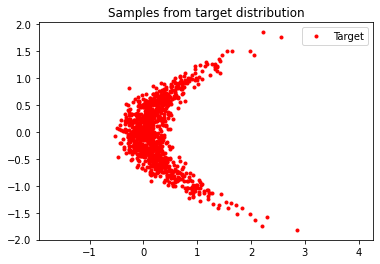

In [4]:
def target_sample(key: PRNGKey, num_samples: int) -> Array:
    """Generates samples from target distribution.

    Args:
      key: a PRNG key.
      num_samples: number of samples to generate.

    Returns:
      An array of shape [num_samples, 2] containing the samples.
    """
    key1, key2 = jax.random.split(key)
    x = 0.6 * jax.random.normal(key1, [num_samples])
    y = 0.8 * x**2 + 0.2 * jax.random.normal(key2, [num_samples])
    return jnp.concatenate([y[:, None], x[:, None]], axis=-1)


# Plot samples from target distribution.
data = target_sample(next(prng), num_samples=1000)
plt.plot(data[:, 0], data[:, 1], ".", color="red", label="Target")
plt.axis("equal")
plt.title("Samples from target distribution")
plt.legend();

## Train model

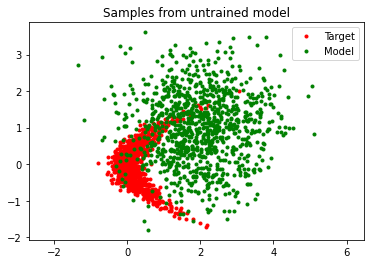

In [5]:
# Initialize model parameters.
params = model_sample.init(next(prng), next(prng), num_samples=1)

# Plot samples from the untrained model.
x = target_sample(next(prng), num_samples=1000)
y = model_sample.apply(params, next(prng), num_samples=1000)
plt.plot(x[:, 0], x[:, 1], ".", color="red", label="Target")
plt.plot(y[:, 0], y[:, 1], ".", color="green", label="Model")
plt.axis("equal")
plt.title("Samples from untrained model")
plt.legend();

In [6]:
# Loss function is negative log likelihood.
loss_fn = jax.jit(lambda params, x: -jnp.mean(model_log_prob.apply(params, x)))

# Optimizer.
optimizer = optax.adam(1e-3)
opt_state = optimizer.init(params)

# Training loop.
for i in range(5000):
    data = target_sample(next(prng), num_samples=100)
    loss, g = jax.value_and_grad(loss_fn)(params, data)
    updates, opt_state = optimizer.update(g, opt_state)
    params = optax.apply_updates(params, updates)

    if i % 100 == 0:
        print(f"Step {i}, loss = {loss:.3f}")

Step 0, loss = 3.890
Step 100, loss = 2.155
Step 200, loss = 1.884
Step 300, loss = 1.783
Step 400, loss = 1.435
Step 500, loss = 1.248
Step 600, loss = 1.212
Step 700, loss = 1.222
Step 800, loss = 1.412
Step 900, loss = 1.269
Step 1000, loss = 1.122
Step 1100, loss = 0.996
Step 1200, loss = 0.970
Step 1300, loss = 0.940
Step 1400, loss = 1.032
Step 1500, loss = 1.028
Step 1600, loss = 0.885
Step 1700, loss = 0.973
Step 1800, loss = 1.917
Step 1900, loss = 1.150
Step 2000, loss = 0.942
Step 2100, loss = 0.835
Step 2200, loss = 1.304
Step 2300, loss = 1.012
Step 2400, loss = 0.833
Step 2500, loss = 0.988
Step 2600, loss = 0.878
Step 2700, loss = 0.918
Step 2800, loss = 0.898
Step 2900, loss = 0.741
Step 3000, loss = 0.849
Step 3100, loss = 0.880
Step 3200, loss = 0.934
Step 3300, loss = 0.739
Step 3400, loss = 0.921
Step 3500, loss = 0.943
Step 3600, loss = 0.939
Step 3700, loss = 0.934
Step 3800, loss = 1.004
Step 3900, loss = 1.106
Step 4000, loss = 1.711
Step 4100, loss = 0.907
Step

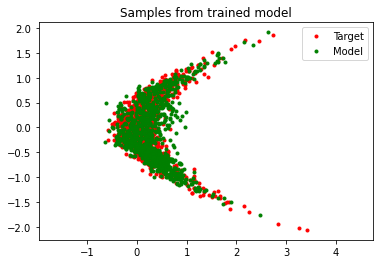

In [7]:
# Plot samples from the trained model.
x = target_sample(next(prng), num_samples=1000)
y = model_sample.apply(params, next(prng), num_samples=1000)
plt.plot(x[:, 0], x[:, 1], ".", color="red", label="Target")
plt.plot(y[:, 0], y[:, 1], ".", color="green", label="Model")
plt.axis("equal")
plt.title("Samples from trained model")
plt.legend();

## Create plot with intermediate distributions

In [8]:
@hk.without_apply_rng
@hk.transform
def model_sample_intermediate(key: PRNGKey, num_samples: int) -> Array:
    model = make_model()
    samples = []
    x = model.distribution.sample(seed=key, sample_shape=[num_samples])
    samples.append(x)
    for layer in model.bijector.bijectors[::-1]:
        x = layer.forward(x)
        samples.append(x)
    return samples


xs = model_sample_intermediate.apply(params, next(prng), num_samples=2000)

/usr/local/lib/python3.7/dist-packages/probml_utils/plotting.py:80: UserWarning: set FIG_DIR environment variable to save figures
  warnings.warn("set FIG_DIR environment variable to save figures")


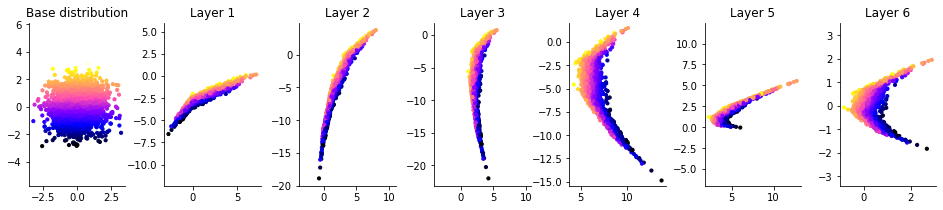

In [10]:
fig, axs = plt.subplots(1, len(xs))

color = xs[0][:, 1]
cm = plt.cm.get_cmap("gnuplot2")


for i, (x, ax) in enumerate(zip(xs, axs)):
    ax.scatter(x[:, 0], x[:, 1], s=10, cmap=cm, c=color)
    ax.axis("equal")
    sns.despine()
    if i == 0:
        title = "Base distribution"
    else:
        title = f"Layer {i}"
    ax.set_title(title)
plt.subplots_adjust(wspace=0.4,left=0.05,right=0.95)
savefig(title,tight_layout=False)
plt.show()